In [209]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import json, os, joblib, math
from itertools import product

import matplotlib.ticker as mticker
import pandas as pd

# EXTRAINDO DADOS

In [210]:
df     = pd.read_csv('../Dataset/model.csv')
TARGET = 'alcohol'
K_CV   = 5
df.head(3)

,decayed,decay,min,auc_recover,auc,mean,median,mean_diff,auc_diff,residual,...,max_diff,first_diff,first,slope_ratio,std_diff,time_peak,time_low,median_diff,alcohol,data
0,False,284,23250,861558,1107213,23557.723404,23281.0,-0.382979,-18.0,-259,...,1341.0,479.0,23534,-0.339346,334.276298,2,34,-2.0,False,"[23534, 24013, 26216, 26172, 26108, 25037, 240..."
1,False,261,23536,872380,1122240,23877.446809,23585.0,-0.361702,-17.0,-201,...,1168.5,367.0,23797,-0.329306,297.088420,3,37,0.5,False,"[23797, 24164, 26134, 26143, 26142, 26120, 253..."
2,False,204,23695,878804,1130612,24055.574468,23765.0,8.680851,408.0,-98,...,1175.0,1006.0,23899,-0.323574,312.737500,3,32,2.0,False,"[23899, 24905, 26249, 26359, 26335, 26225, 254..."


In [211]:
xData = df.drop(columns=[TARGET, 'data'])
yData = df[TARGET].values

N_STATES = len(xData.columns)
print('n states: ', N_STATES)

xData

n states:  25


,decayed,decay,min,auc_recover,auc,mean,median,mean_diff,auc_diff,residual,...,min_diff,rise,max_diff,first_diff,first,slope_ratio,std_diff,time_peak,time_low,median_diff
0,False,284,23250,861558,1107213,23557.723404,23281.0,-0.382979,-18.0,-259,...,-1006.5,-2682,1341.0,479.0,23534,-0.339346,334.276298,2,34,-2.0
1,False,261,23536,872380,1122240,23877.446809,23585.0,-0.361702,-17.0,-201,...,-858.5,-2346,1168.5,367.0,23797,-0.329306,297.088420,3,37,0.5
2,False,204,23695,878804,1130612,24055.574468,23765.0,8.680851,408.0,-98,...,-862.0,-2460,1175.0,1006.0,23899,-0.323574,312.737500,3,32,2.0
3,False,444,23523,874099,1131125,24066.489362,23586.0,-4.787234,-225.0,-414,...,-796.0,-2318,1159.0,417.0,23967,-0.288197,286.202777,2,29,-3.5
4,False,33,23826,892564,1141993,24297.723404,23938.0,6.361702,299.0,84,...,-849.5,-2410,1205.0,428.0,23859,-0.347728,397.356656,2,25,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,True,11393,13375,533428,714328,15198.468085,14317.0,-176.829787,-8311.0,-8605,...,-2559.0,-289,352.5,289.0,24768,-0.219055,689.233240,1,10,28.0
762,True,5913,14395,610531,776514,16521.574468,16617.0,-36.212766,-1702.0,-2181,...,-2373.0,-854,854.0,854.0,20308,-0.350672,535.349416,1,8,64.0
763,True,6870,16731,711705,912089,19406.148936,19572.0,-44.382979,-2086.0,-2382,...,-2344.0,-527,527.0,527.0,23601,-0.316885,497.244639,1,10,97.0
764,True,6607,16689,737606,933893,19870.063830,20383.0,-42.031915,-1975.5,-2172,...,-2803.5,-1037,594.0,594.0,23296,-0.366758,580.054105,2,8,79.0


# SELECIONANDO MODELO

In [212]:
from Selector.index import ModelSelector

In [213]:
selector = ModelSelector('logistic_regression')
model, params = selector.get()
model

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


# APLICANDO GRID SEARCH

In [214]:
from GridSearch.index import GridSearch

In [215]:
grid = GridSearch(model, params, xData, yData, K_CV)
grid.update()

model, auc = grid.evaluate()
print('best_auc:', auc)
model

Fitting 5 folds for each of 528 candidates, totalling 2640 fits
best_auc: 0.9967948717948718


,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l1'
,dual,False
,tol,0.0001
,C,1


# AVALIAÇÃO GAUSSIANA
O valor mais provável em uma distribuição gaussiana é a média, com a relação

$$\mu \pm t\cdot\frac{\sigma_a}{\sqrt{n}}$$

- $\sigma_a$ é o desvio padrão amostral, considerando $n-1$ graus de liberade (ddof no numpy)
- $\mu$ é a média
- $t$ é o t_student para corrigir a amostra com $n$-1 e aqui vamos adotar a tabela para 95% de confiança (os dados vão cair em um intervalo $\pm$ ... com 95% de confiança) 

In [216]:
from Metrics.CrossValidation.index import CrossValidation
from Metrics.GaussianAnalyser.index import GaussianAnalyser

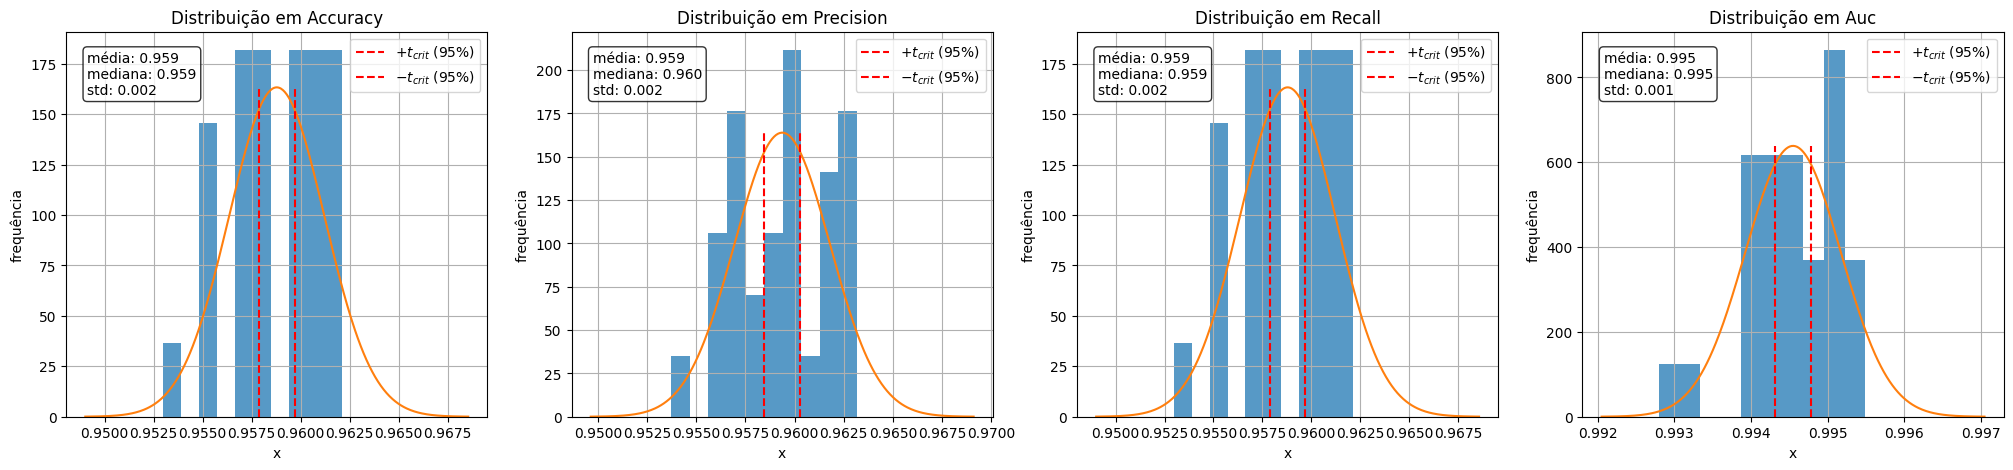

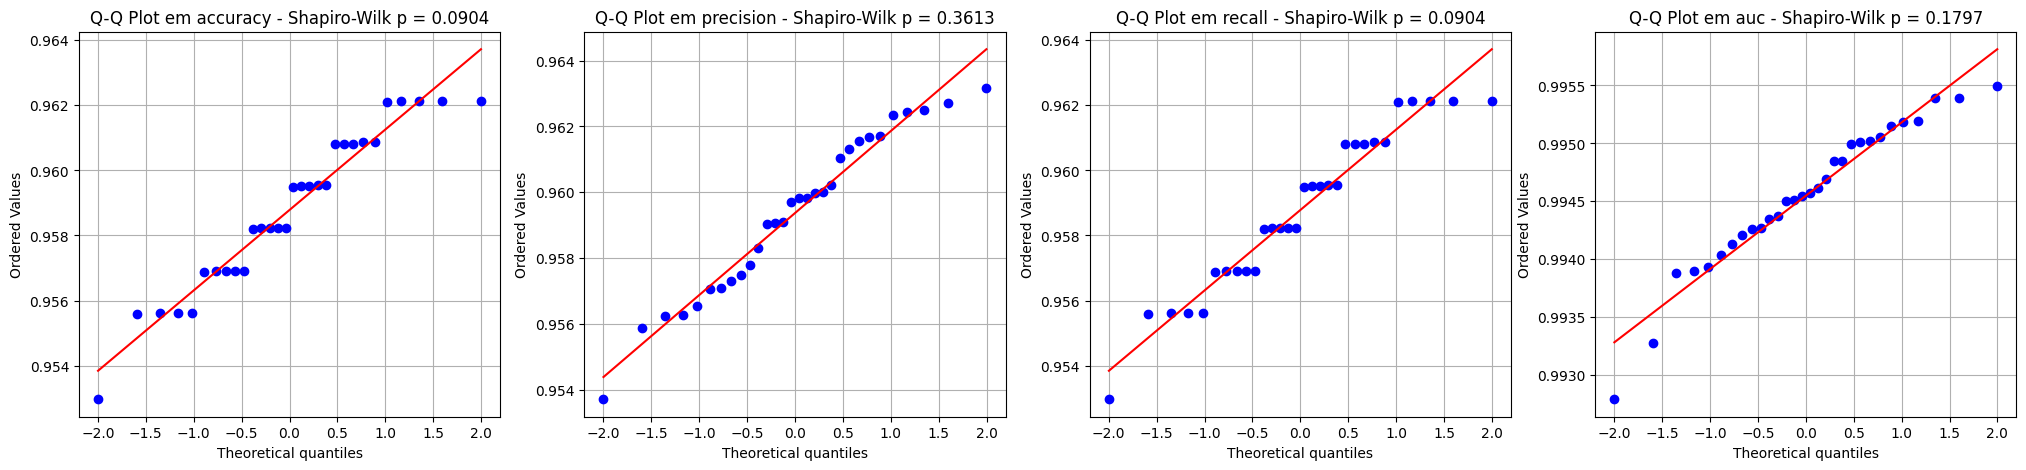

{'accuracy': 0.9587833517245286,
 'precision': 0.9593673002787841,
 'recall': 0.9587833517245286,
 'auc': 0.9945483662536295}

In [217]:
cross    = CrossValidation(model, xData, yData, K_CV)
analyser = GaussianAnalyser(cross)
analyser.update()
analyser.plot()
analyser.info()

# RESULTADOS

In [218]:
from Metrics.ROC.index import RocCurve
from Metrics.ConfusionMatrix.index import ConfusionMatrix
from Metrics.Plotter.index import Plotter

In [219]:
cross.print()

ACCURACY: 95.95% (±1.27%)
PRECISION: 96.00% (±1.27%)
RECALL: 95.95% (±1.27%)
ROC_AUC: 99.39% (±0.32%)


,name,values,mean,std,min,max,k0,k1,k2,k3,k4
0,accuracy,"[0.9805194805194806, 0.954248366013072, 0.9673...",0.959503,0.012716,0.947712,0.980519,0.980519,0.954248,0.967320,0.947712,0.947712
1,precision,"[0.981240981240981, 0.9543298978283499, 0.9674...",0.959971,0.012695,0.947992,0.981241,0.981241,0.954330,0.967403,0.948889,0.947992
2,recall,"[0.9805194805194806, 0.954248366013072, 0.9673...",0.959503,0.012716,0.947712,0.980519,0.980519,0.954248,0.967320,0.947712,0.947712
3,roc_auc,"[0.9979757085020243, 0.9962406015037594, 0.994...",0.993886,0.003186,0.989402,0.997976,0.997976,0.996241,0.994703,0.989402,0.991111


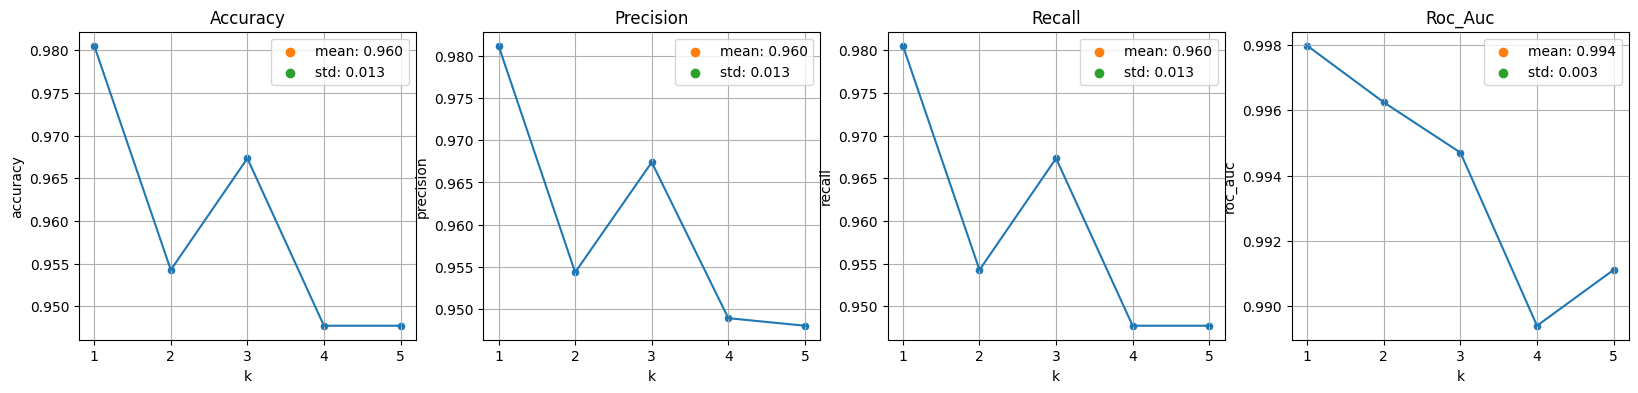

In [220]:
cross.plot()

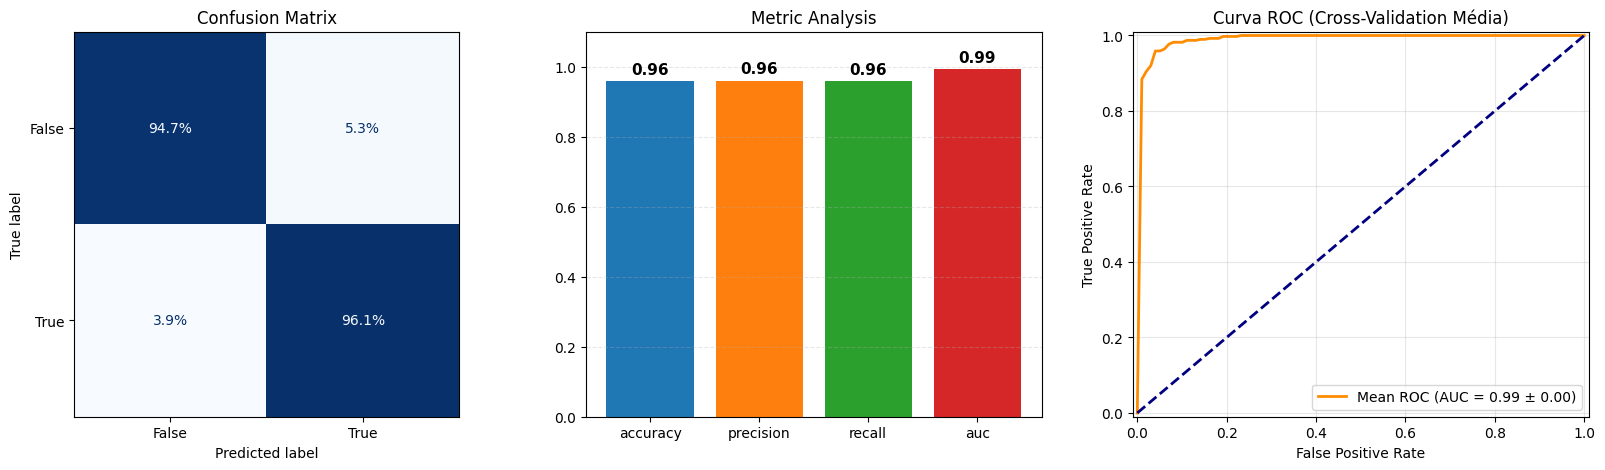

In [227]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
ConfusionMatrix(model, xData, yData, cross.cv).plot()

plt.subplot(1, 3, 2)
Plotter(cross.info(), limits=(0, 1.10))

plt.subplot(1, 3, 3)
RocCurve(model, xData, yData, cross.cv).plot()

# TREINANDO MODELO FINAL

In [221]:
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.preprocessing import label_binarize

In [222]:
model, params = selector.get()
model.fit(xData, yData)
model.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('model', LogisticRegression())],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'model': LogisticRegression(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 100,
 'model__multi_class': 'deprecated',
 'model__n_jobs': None,
 'model__penalty': 'l2',
 'model__random_state': None,
 'model__solver': 'lbfgs',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [223]:
yProba = model.predict_proba(xData)
yBin   = label_binarize(yData, classes=model.classes_)

if yBin.shape[1] == 1 and len(model.classes_) == 2:
    yBin = np.hstack((1 - yBin, yBin))

treshHistory  = []
bestTresholds = {}
scaled_probas = np.zeros_like(yProba)

for i in range(len(model.classes_)):
    fpr, tpr, thresholds = roc_curve(yBin[:, i], yProba[:, i])    
    J   = tpr - fpr
    idx = np.argmax(J)
    best_thresh = thresholds[idx] if thresholds[idx] > 0.01 else 0.01 
    
    bestTresholds[model.classes_[i]] = best_thresh
    scaled_probas[:, i] = yProba[:, i] / best_thresh
    data = {'class': model.classes_[i], 'treshold': best_thresh}
    treshHistory.append(data)
    print(data)

yStandard = model.classes_[np.argmax(yProba, axis=1)]
yBest     = model.classes_[np.argmax(scaled_probas, axis=1)]

acc_padrao = accuracy_score(yData, yStandard) * 100
acc_best   = accuracy_score(yData, yBest)     * 100

print()
print(f'Acurácia Padrão (Argmax): {acc_padrao:.3f}%')
print(f'Acurácia Ótima (Scaled):  {acc_best:.3f}%')

{'class': np.False_, 'treshold': np.float64(0.4904492732928343)}
{'class': np.True_, 'treshold': np.float64(0.512222389065927)}

Acurácia Padrão (Argmax): 96.345%
Acurácia Ótima (Scaled):  96.475%


In [224]:
model

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


# SALVANDO O MODELO

In [225]:
results = {
    'model': selector.chosen,
    'params': {key: str(value) for key, value in model.get_params().items()},
    'K_CV': K_CV,
    'variables': list(xData.columns),
    'info': analyser.info(),
    'thresholds': treshHistory,
    'variables': xData.columns.tolist()
}

display(pd.DataFrame([results.get('info')]))
results

,accuracy,precision,recall,auc
0,0.958783,0.959367,0.958783,0.994548


{'model': 'logistic_regression',
 'params': {'memory': 'None',
  'steps': "[('scaler', StandardScaler()), ('model', LogisticRegression())]",
  'transform_input': 'None',
  'verbose': 'False',
  'scaler': 'StandardScaler()',
  'model': 'LogisticRegression()',
  'scaler__copy': 'True',
  'scaler__with_mean': 'True',
  'scaler__with_std': 'True',
  'model__C': '1.0',
  'model__class_weight': 'None',
  'model__dual': 'False',
  'model__fit_intercept': 'True',
  'model__intercept_scaling': '1',
  'model__l1_ratio': 'None',
  'model__max_iter': '100',
  'model__multi_class': 'deprecated',
  'model__n_jobs': 'None',
  'model__penalty': 'l2',
  'model__random_state': 'None',
  'model__solver': 'lbfgs',
  'model__tol': '0.0001',
  'model__verbose': '0',
  'model__warm_start': 'False'},
 'K_CV': 5,
 'variables': ['decayed',
  'decay',
  'min',
  'auc_recover',
  'auc',
  'mean',
  'median',
  'mean_diff',
  'auc_diff',
  'residual',
  'last',
  'reldecay',
  'amplitude',
  'std',
  'max',
  'min

In [226]:
os.makedirs('Backup', exist_ok=True)
index  = len(os.listdir('Backup')) + 1

output = f'Backup/model_{index}'
os.makedirs(output, exist_ok=True)

pd.Series(results).to_json(os.path.join(output, 'info.json'), indent=4)
joblib.dump(model, os.path.join(output, 'model.pkl'))

['Backup/model_1/model.pkl']